In [2]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import pandas as pd

import matplotlib.pyplot as plt


In [2]:
img_shape = (1500, 2)
cuda = False

In [3]:



class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity



In [4]:

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# if cuda:
#     generator.cuda()
#     discriminator.cuda()
#     adversarial_loss.cuda()

# Configure data loader



In [3]:
dat = pd.read_csv("Minute_Trajectories.csv")

In [8]:
print(np.shape(dat.loc[dat['minute_id'] == 1]))

(1500, 27)


In [9]:
dat_np = np.zeros((2373,1500,2))
for i in range(1,2373):
    dat_np[i] = dat.loc[dat['minute_id'] == i][["x",'y']]
    
dataloader = torch.utils.data.DataLoader(dat_np, batch_size=128,shuffle=True)

In [10]:


# Optimizers
optlr = 0.0002
optb1 = 0.5
optb2 = 0.999
optimizer_G = torch.optim.Adam(generator.parameters(), lr=optlr, betas=(optb1, optb2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=optlr, betas=(optb1, optb2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


In [11]:

# ----------
#  Training
# ----------
n_epochs = 1000
for epoch in range(n_epochs):
    for i, imgs in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    print(
        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
    )

#         batches_done = epoch * len(dataloader) + i
#         if batches_done % 25 == 0:
#             save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)


[Epoch 0/1000] [Batch 18/19] [D loss: 0.435010] [G loss: 0.543575]
[Epoch 1/1000] [Batch 18/19] [D loss: 0.514483] [G loss: 0.445531]
[Epoch 2/1000] [Batch 18/19] [D loss: 0.257431] [G loss: 0.911241]
[Epoch 3/1000] [Batch 18/19] [D loss: 0.389793] [G loss: 0.746700]
[Epoch 4/1000] [Batch 18/19] [D loss: 0.287841] [G loss: 0.827876]
[Epoch 5/1000] [Batch 18/19] [D loss: 0.313355] [G loss: 0.780423]
[Epoch 6/1000] [Batch 18/19] [D loss: 15.968351] [G loss: 0.615445]
[Epoch 7/1000] [Batch 18/19] [D loss: 0.782023] [G loss: 0.305643]
[Epoch 8/1000] [Batch 18/19] [D loss: 1.494290] [G loss: 0.214630]
[Epoch 9/1000] [Batch 18/19] [D loss: 1.171990] [G loss: 0.230167]
[Epoch 10/1000] [Batch 18/19] [D loss: 1.392967] [G loss: 0.331387]
[Epoch 11/1000] [Batch 18/19] [D loss: 1.059075] [G loss: 0.179848]
[Epoch 12/1000] [Batch 18/19] [D loss: 1.855548] [G loss: 0.045897]
[Epoch 13/1000] [Batch 18/19] [D loss: 0.836219] [G loss: 0.228131]
[Epoch 14/1000] [Batch 18/19] [D loss: 10.288070] [G loss

[Epoch 121/1000] [Batch 18/19] [D loss: 0.581247] [G loss: 0.382146]
[Epoch 122/1000] [Batch 18/19] [D loss: 0.200671] [G loss: 1.109616]
[Epoch 123/1000] [Batch 18/19] [D loss: 0.699263] [G loss: 0.315539]
[Epoch 124/1000] [Batch 18/19] [D loss: 0.213480] [G loss: 1.090081]
[Epoch 125/1000] [Batch 18/19] [D loss: 1.127113] [G loss: 0.380064]
[Epoch 126/1000] [Batch 18/19] [D loss: 0.200307] [G loss: 1.108996]
[Epoch 127/1000] [Batch 18/19] [D loss: 1.147811] [G loss: 0.289552]
[Epoch 128/1000] [Batch 18/19] [D loss: 0.257942] [G loss: 0.932814]
[Epoch 129/1000] [Batch 18/19] [D loss: 2.183793] [G loss: 0.141399]
[Epoch 130/1000] [Batch 18/19] [D loss: 0.498226] [G loss: 0.512679]
[Epoch 131/1000] [Batch 18/19] [D loss: 0.239408] [G loss: 0.984663]
[Epoch 132/1000] [Batch 18/19] [D loss: 0.263429] [G loss: 0.907741]
[Epoch 133/1000] [Batch 18/19] [D loss: 0.176810] [G loss: 1.213967]
[Epoch 134/1000] [Batch 18/19] [D loss: 0.157521] [G loss: 1.313242]
[Epoch 135/1000] [Batch 18/19] [D 

[Epoch 240/1000] [Batch 18/19] [D loss: 0.325430] [G loss: 0.934404]
[Epoch 241/1000] [Batch 18/19] [D loss: 0.274738] [G loss: 1.185427]
[Epoch 242/1000] [Batch 18/19] [D loss: 0.629076] [G loss: 0.770061]
[Epoch 243/1000] [Batch 18/19] [D loss: 0.288062] [G loss: 1.020861]
[Epoch 244/1000] [Batch 18/19] [D loss: 0.249352] [G loss: 1.111788]
[Epoch 245/1000] [Batch 18/19] [D loss: 0.172327] [G loss: 1.273822]
[Epoch 246/1000] [Batch 18/19] [D loss: 0.900496] [G loss: 0.255994]
[Epoch 247/1000] [Batch 18/19] [D loss: 0.472006] [G loss: 0.621784]
[Epoch 248/1000] [Batch 18/19] [D loss: 0.219706] [G loss: 1.094434]
[Epoch 249/1000] [Batch 18/19] [D loss: 0.121142] [G loss: 1.561829]
[Epoch 250/1000] [Batch 18/19] [D loss: 0.121602] [G loss: 1.621613]
[Epoch 251/1000] [Batch 18/19] [D loss: 0.189997] [G loss: 1.158460]
[Epoch 252/1000] [Batch 18/19] [D loss: 0.109005] [G loss: 1.680744]
[Epoch 253/1000] [Batch 18/19] [D loss: 0.077003] [G loss: 2.016431]
[Epoch 254/1000] [Batch 18/19] [D 

[Epoch 359/1000] [Batch 18/19] [D loss: 0.042440] [G loss: 2.550218]
[Epoch 360/1000] [Batch 18/19] [D loss: 0.223882] [G loss: 1.546127]
[Epoch 361/1000] [Batch 18/19] [D loss: 0.104192] [G loss: 1.853728]
[Epoch 362/1000] [Batch 18/19] [D loss: 0.057867] [G loss: 2.247189]
[Epoch 363/1000] [Batch 18/19] [D loss: 0.285029] [G loss: 1.783227]
[Epoch 364/1000] [Batch 18/19] [D loss: 0.073896] [G loss: 2.050314]
[Epoch 365/1000] [Batch 18/19] [D loss: 0.040955] [G loss: 2.558119]
[Epoch 366/1000] [Batch 18/19] [D loss: 0.029741] [G loss: 2.861598]
[Epoch 367/1000] [Batch 18/19] [D loss: 0.026179] [G loss: 2.997383]
[Epoch 368/1000] [Batch 18/19] [D loss: 0.026618] [G loss: 2.998332]
[Epoch 369/1000] [Batch 18/19] [D loss: 0.027088] [G loss: 2.979862]
[Epoch 370/1000] [Batch 18/19] [D loss: 0.029298] [G loss: 2.905416]
[Epoch 371/1000] [Batch 18/19] [D loss: 0.023613] [G loss: 3.097138]
[Epoch 372/1000] [Batch 18/19] [D loss: 0.020736] [G loss: 3.215732]
[Epoch 373/1000] [Batch 18/19] [D 

[Epoch 478/1000] [Batch 18/19] [D loss: 0.004696] [G loss: 4.676600]
[Epoch 479/1000] [Batch 18/19] [D loss: 0.004604] [G loss: 4.696080]
[Epoch 480/1000] [Batch 18/19] [D loss: 0.004534] [G loss: 4.710071]
[Epoch 481/1000] [Batch 18/19] [D loss: 0.004502] [G loss: 4.717461]
[Epoch 482/1000] [Batch 18/19] [D loss: 0.004490] [G loss: 4.721777]
[Epoch 483/1000] [Batch 18/19] [D loss: 0.004553] [G loss: 4.715910]
[Epoch 484/1000] [Batch 18/19] [D loss: 0.004588] [G loss: 4.707324]
[Epoch 485/1000] [Batch 18/19] [D loss: 0.004558] [G loss: 4.709562]
[Epoch 486/1000] [Batch 18/19] [D loss: 0.004323] [G loss: 4.764009]
[Epoch 487/1000] [Batch 18/19] [D loss: 0.004268] [G loss: 4.777124]
[Epoch 488/1000] [Batch 18/19] [D loss: 0.003961] [G loss: 4.845772]
[Epoch 489/1000] [Batch 18/19] [D loss: 0.004086] [G loss: 4.818165]
[Epoch 490/1000] [Batch 18/19] [D loss: 0.004221] [G loss: 4.800150]
[Epoch 491/1000] [Batch 18/19] [D loss: 0.004146] [G loss: 4.801658]
[Epoch 492/1000] [Batch 18/19] [D 

[Epoch 597/1000] [Batch 18/19] [D loss: 0.001154] [G loss: 6.074454]
[Epoch 598/1000] [Batch 18/19] [D loss: 0.001163] [G loss: 6.067605]
[Epoch 599/1000] [Batch 18/19] [D loss: 0.001191] [G loss: 6.048306]
[Epoch 600/1000] [Batch 18/19] [D loss: 0.001194] [G loss: 6.056826]
[Epoch 601/1000] [Batch 18/19] [D loss: 0.001176] [G loss: 6.068936]
[Epoch 602/1000] [Batch 18/19] [D loss: 0.001129] [G loss: 6.102707]
[Epoch 603/1000] [Batch 18/19] [D loss: 0.001074] [G loss: 6.149558]
[Epoch 604/1000] [Batch 18/19] [D loss: 0.001072] [G loss: 6.150928]
[Epoch 605/1000] [Batch 18/19] [D loss: 0.001081] [G loss: 6.139417]
[Epoch 606/1000] [Batch 18/19] [D loss: 0.001046] [G loss: 6.172891]
[Epoch 607/1000] [Batch 18/19] [D loss: 0.001065] [G loss: 6.162735]
[Epoch 608/1000] [Batch 18/19] [D loss: 0.001107] [G loss: 6.131922]
[Epoch 609/1000] [Batch 18/19] [D loss: 0.001142] [G loss: 6.097201]
[Epoch 610/1000] [Batch 18/19] [D loss: 0.001110] [G loss: 6.120989]
[Epoch 611/1000] [Batch 18/19] [D 

[Epoch 716/1000] [Batch 18/19] [D loss: 0.000391] [G loss: 7.161101]
[Epoch 717/1000] [Batch 18/19] [D loss: 0.000385] [G loss: 7.175131]
[Epoch 718/1000] [Batch 18/19] [D loss: 0.000389] [G loss: 7.165290]
[Epoch 719/1000] [Batch 18/19] [D loss: 0.000383] [G loss: 7.176727]
[Epoch 720/1000] [Batch 18/19] [D loss: 0.000385] [G loss: 7.170589]
[Epoch 721/1000] [Batch 18/19] [D loss: 0.000380] [G loss: 7.183338]
[Epoch 722/1000] [Batch 18/19] [D loss: 0.000385] [G loss: 7.174174]
[Epoch 723/1000] [Batch 18/19] [D loss: 0.000380] [G loss: 7.189634]
[Epoch 724/1000] [Batch 18/19] [D loss: 0.000365] [G loss: 7.228659]
[Epoch 725/1000] [Batch 18/19] [D loss: 0.000357] [G loss: 7.252800]
[Epoch 726/1000] [Batch 18/19] [D loss: 0.000361] [G loss: 7.239568]
[Epoch 727/1000] [Batch 18/19] [D loss: 0.000362] [G loss: 7.236519]
[Epoch 728/1000] [Batch 18/19] [D loss: 0.000365] [G loss: 7.224980]
[Epoch 729/1000] [Batch 18/19] [D loss: 0.000369] [G loss: 7.214323]
[Epoch 730/1000] [Batch 18/19] [D 

[Epoch 835/1000] [Batch 18/19] [D loss: 0.000222] [G loss: 7.728901]
[Epoch 836/1000] [Batch 18/19] [D loss: 0.000226] [G loss: 7.705609]
[Epoch 837/1000] [Batch 18/19] [D loss: 0.000229] [G loss: 7.691703]
[Epoch 838/1000] [Batch 18/19] [D loss: 0.000233] [G loss: 7.679082]
[Epoch 839/1000] [Batch 18/19] [D loss: 0.000231] [G loss: 7.683819]
[Epoch 840/1000] [Batch 18/19] [D loss: 0.000228] [G loss: 7.691740]
[Epoch 841/1000] [Batch 18/19] [D loss: 0.000226] [G loss: 7.704770]
[Epoch 842/1000] [Batch 18/19] [D loss: 0.000216] [G loss: 7.751612]
[Epoch 843/1000] [Batch 18/19] [D loss: 0.000216] [G loss: 7.751827]
[Epoch 844/1000] [Batch 18/19] [D loss: 0.000218] [G loss: 7.743808]
[Epoch 845/1000] [Batch 18/19] [D loss: 0.000213] [G loss: 7.763283]
[Epoch 846/1000] [Batch 18/19] [D loss: 0.000215] [G loss: 7.753232]
[Epoch 847/1000] [Batch 18/19] [D loss: 0.000217] [G loss: 7.742361]
[Epoch 848/1000] [Batch 18/19] [D loss: 0.000215] [G loss: 7.752129]
[Epoch 849/1000] [Batch 18/19] [D 

[Epoch 954/1000] [Batch 18/19] [D loss: 0.000209] [G loss: 7.779602]
[Epoch 955/1000] [Batch 18/19] [D loss: 0.000211] [G loss: 7.772402]
[Epoch 956/1000] [Batch 18/19] [D loss: 0.000204] [G loss: 7.802644]
[Epoch 957/1000] [Batch 18/19] [D loss: 0.000209] [G loss: 7.779957]
[Epoch 958/1000] [Batch 18/19] [D loss: 0.000208] [G loss: 7.785783]
[Epoch 959/1000] [Batch 18/19] [D loss: 0.000209] [G loss: 7.780636]
[Epoch 960/1000] [Batch 18/19] [D loss: 0.000211] [G loss: 7.770339]
[Epoch 961/1000] [Batch 18/19] [D loss: 0.000208] [G loss: 7.787582]
[Epoch 962/1000] [Batch 18/19] [D loss: 0.000214] [G loss: 7.760038]
[Epoch 963/1000] [Batch 18/19] [D loss: 0.000214] [G loss: 7.760464]
[Epoch 964/1000] [Batch 18/19] [D loss: 0.000213] [G loss: 7.762662]
[Epoch 965/1000] [Batch 18/19] [D loss: 0.000204] [G loss: 7.808000]
[Epoch 966/1000] [Batch 18/19] [D loss: 0.000212] [G loss: 7.766048]
[Epoch 967/1000] [Batch 18/19] [D loss: 0.000212] [G loss: 7.768166]
[Epoch 968/1000] [Batch 18/19] [D 

In [12]:
# Sample noise as generator input
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

# Generate a batch of images
gen_imgs = generator(z)

In [13]:
print(np.shape(gen_imgs))

torch.Size([69, 1500, 2])


In [14]:
print(np.shape(gen_imgs[0]))

torch.Size([1500, 2])


In [15]:
gen_np = gen_imgs.detach().numpy()

In [16]:
print(np.shape(gen_np[0,:,0]))

(1500,)


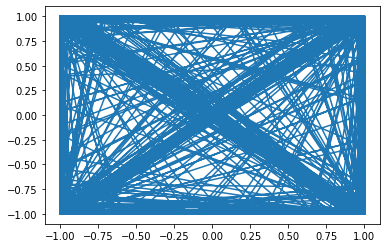

In [17]:
plt.plot(gen_np[0,:,0],gen_np[0,:,1])